In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def read_files(files):
    ret = []
    for f in files:
        ret += [pd.read_csv(f)]
    return ret

STATS_DIR = 'stats/hash'
HASH_FUNCS = ['hash::zero', 'hash::firstChar', 'hash::strlen', 'hash::sum',
              'hash::ror', 'hash::rol', 'hash::crc32', 'hash::gnu']

stats = read_files([f'{STATS_DIR}/{hash_func}.csv' for hash_func in HASH_FUNCS])
nums = [st['num'] for st in stats]
loads = [st['load'] for st in stats]

In [2]:
def plot_hash_func(num, load_factor, title, xlim):
    plt.figure(figsize=(12, 4), dpi=200)
    plt.xlim(xlim)
    plt.bar(num, load_factor, color='red', width=1.5)
    plt.xlabel('Значение хеша')
    plt.ylabel('Число коллизий')
    plt.title(title)
    plt.savefig(f'graphs/{title}.png')

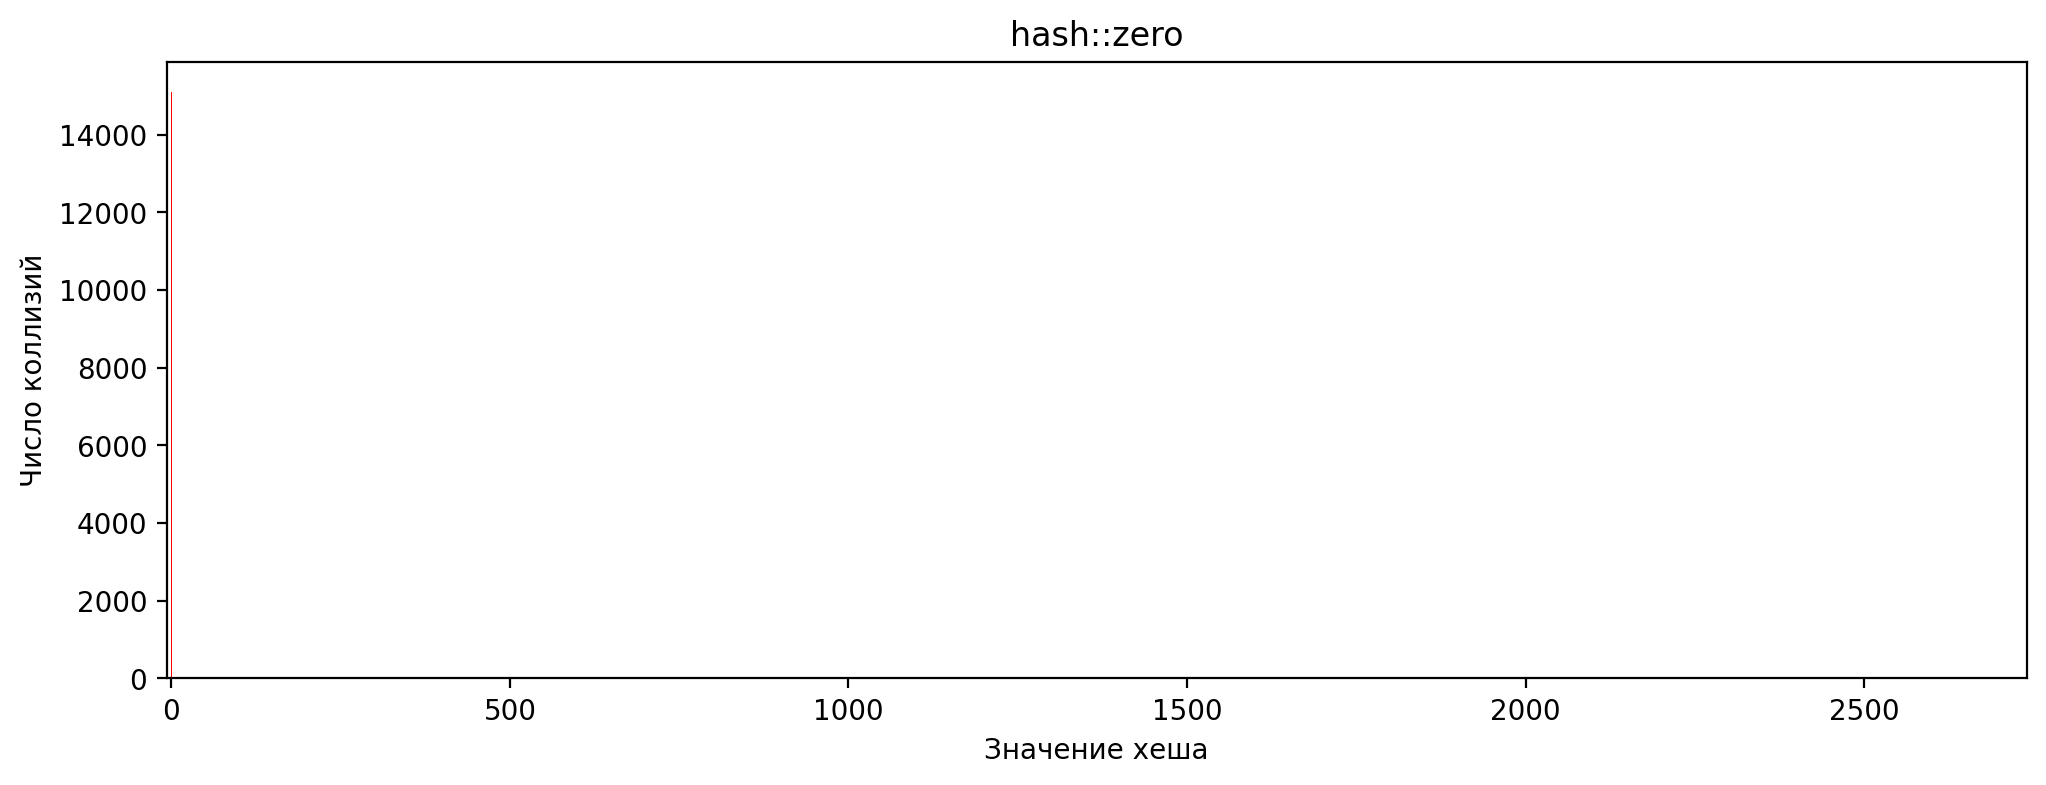

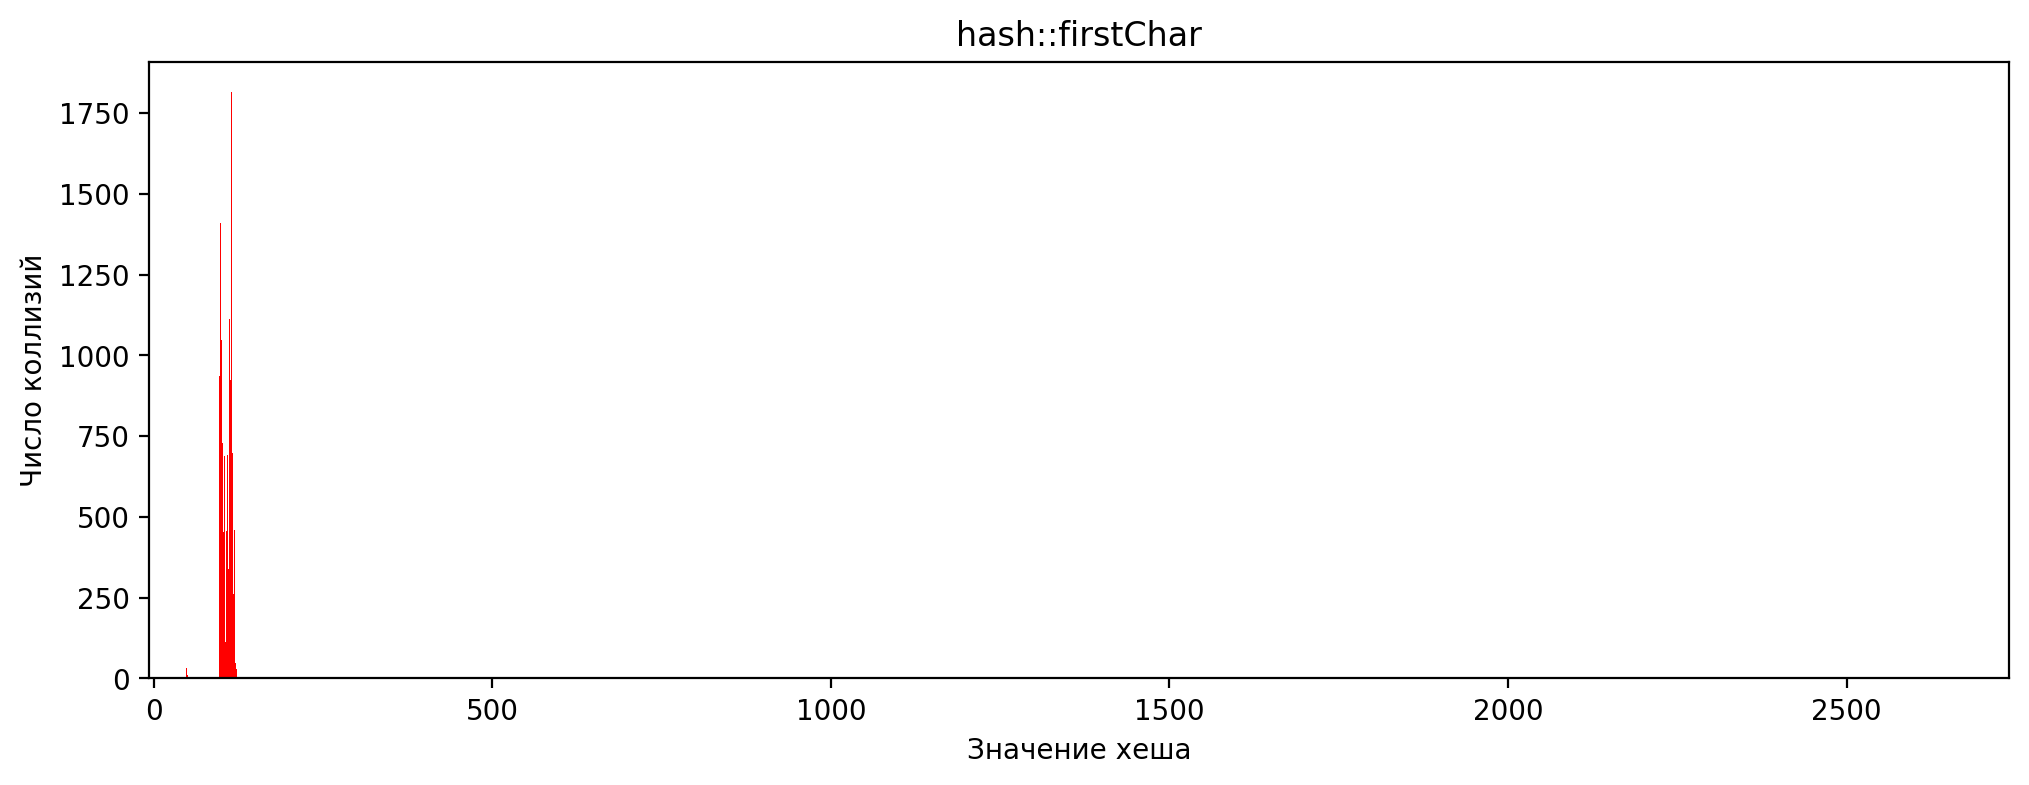

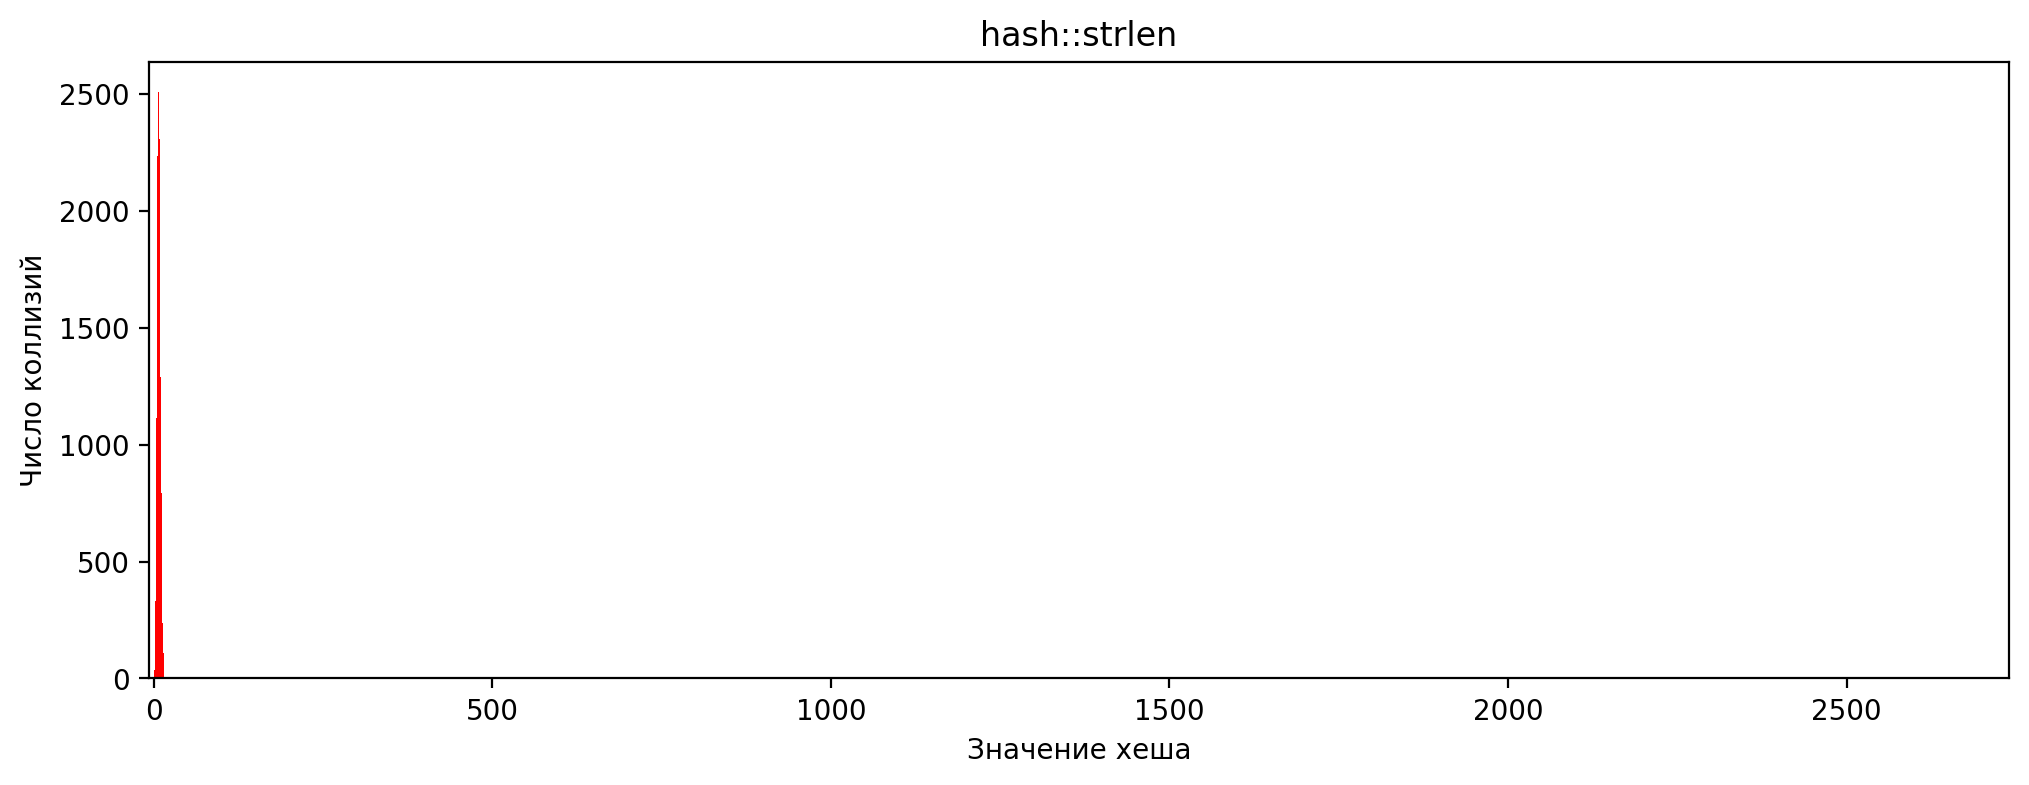

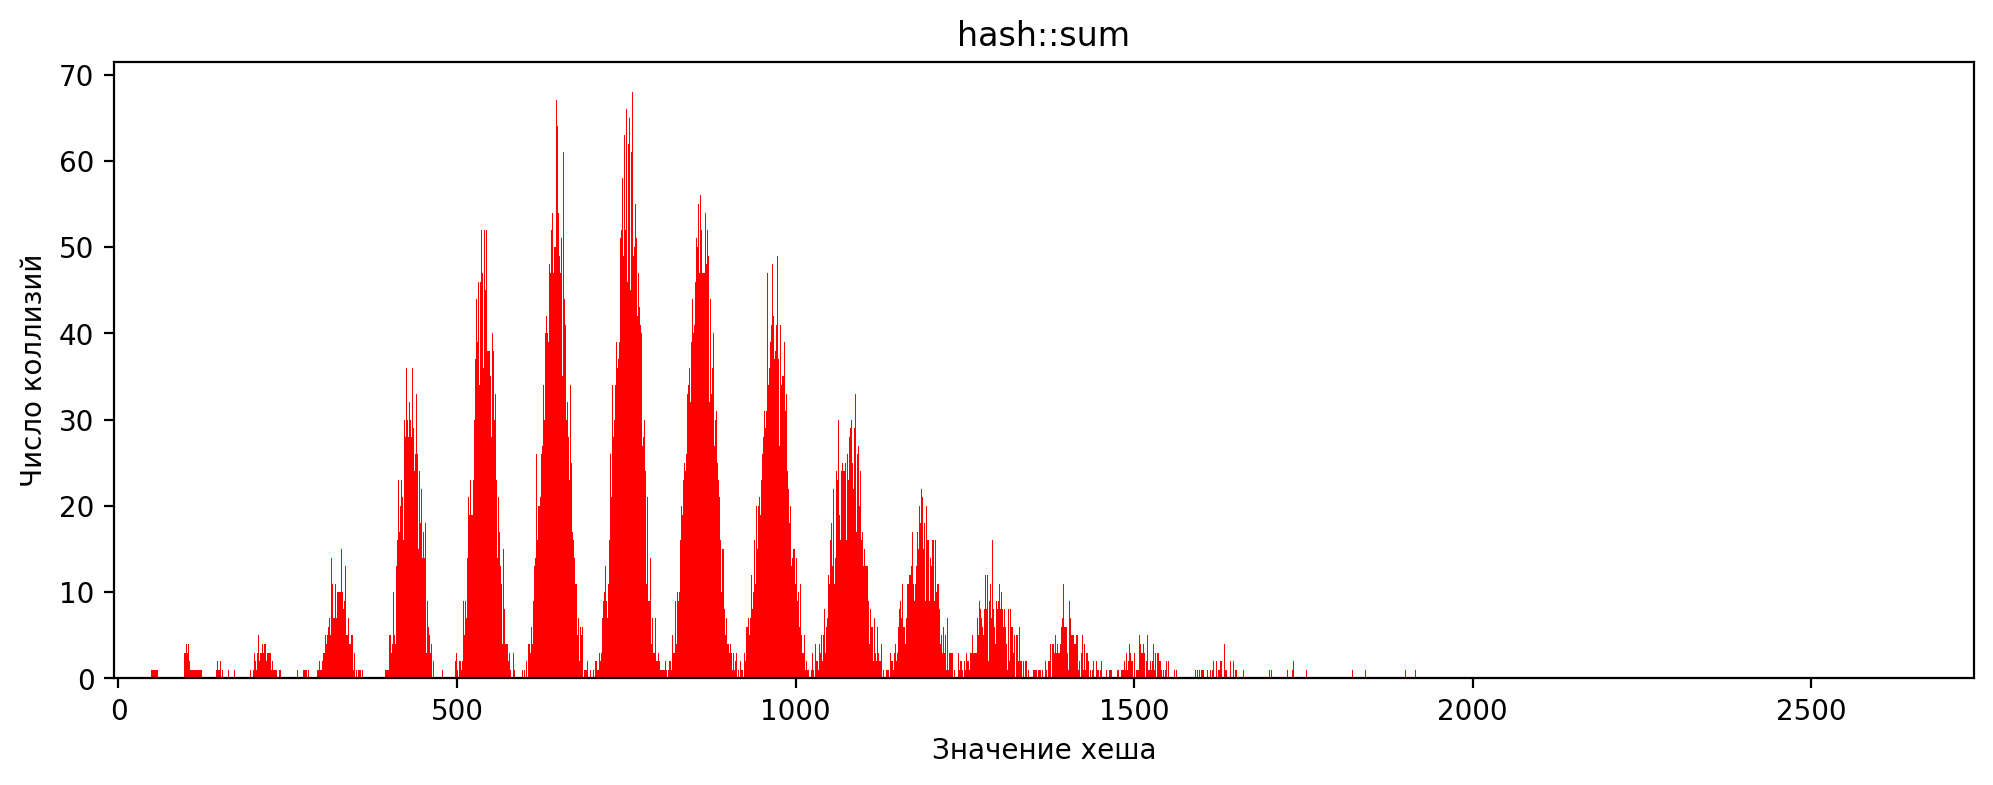

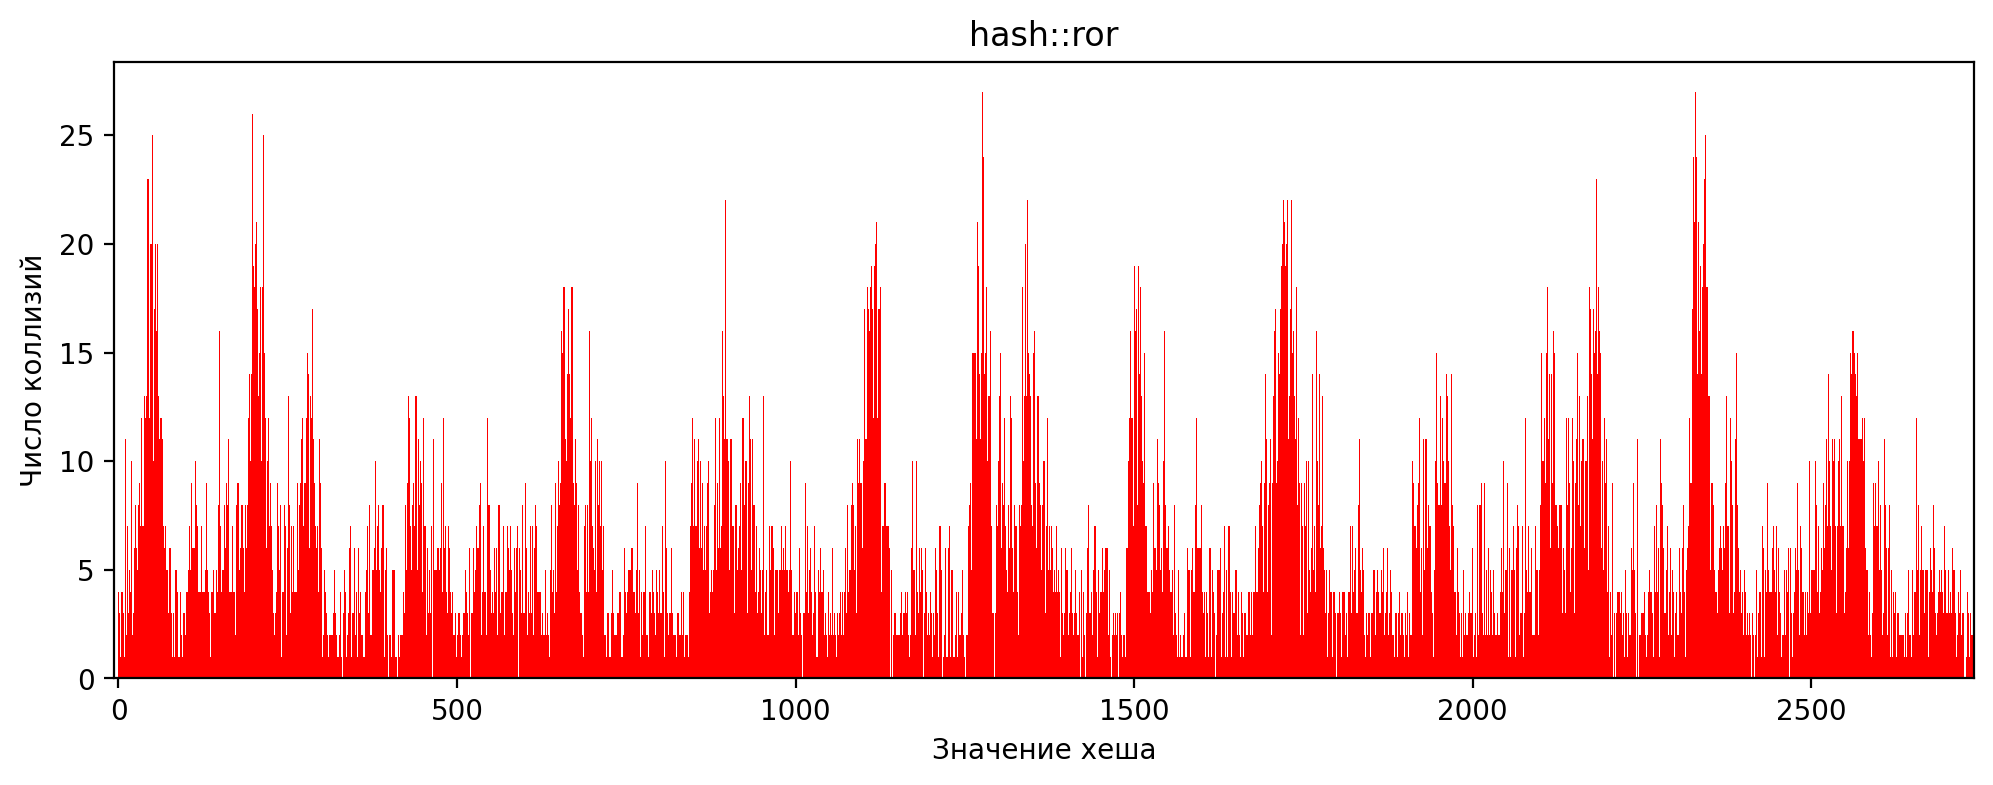

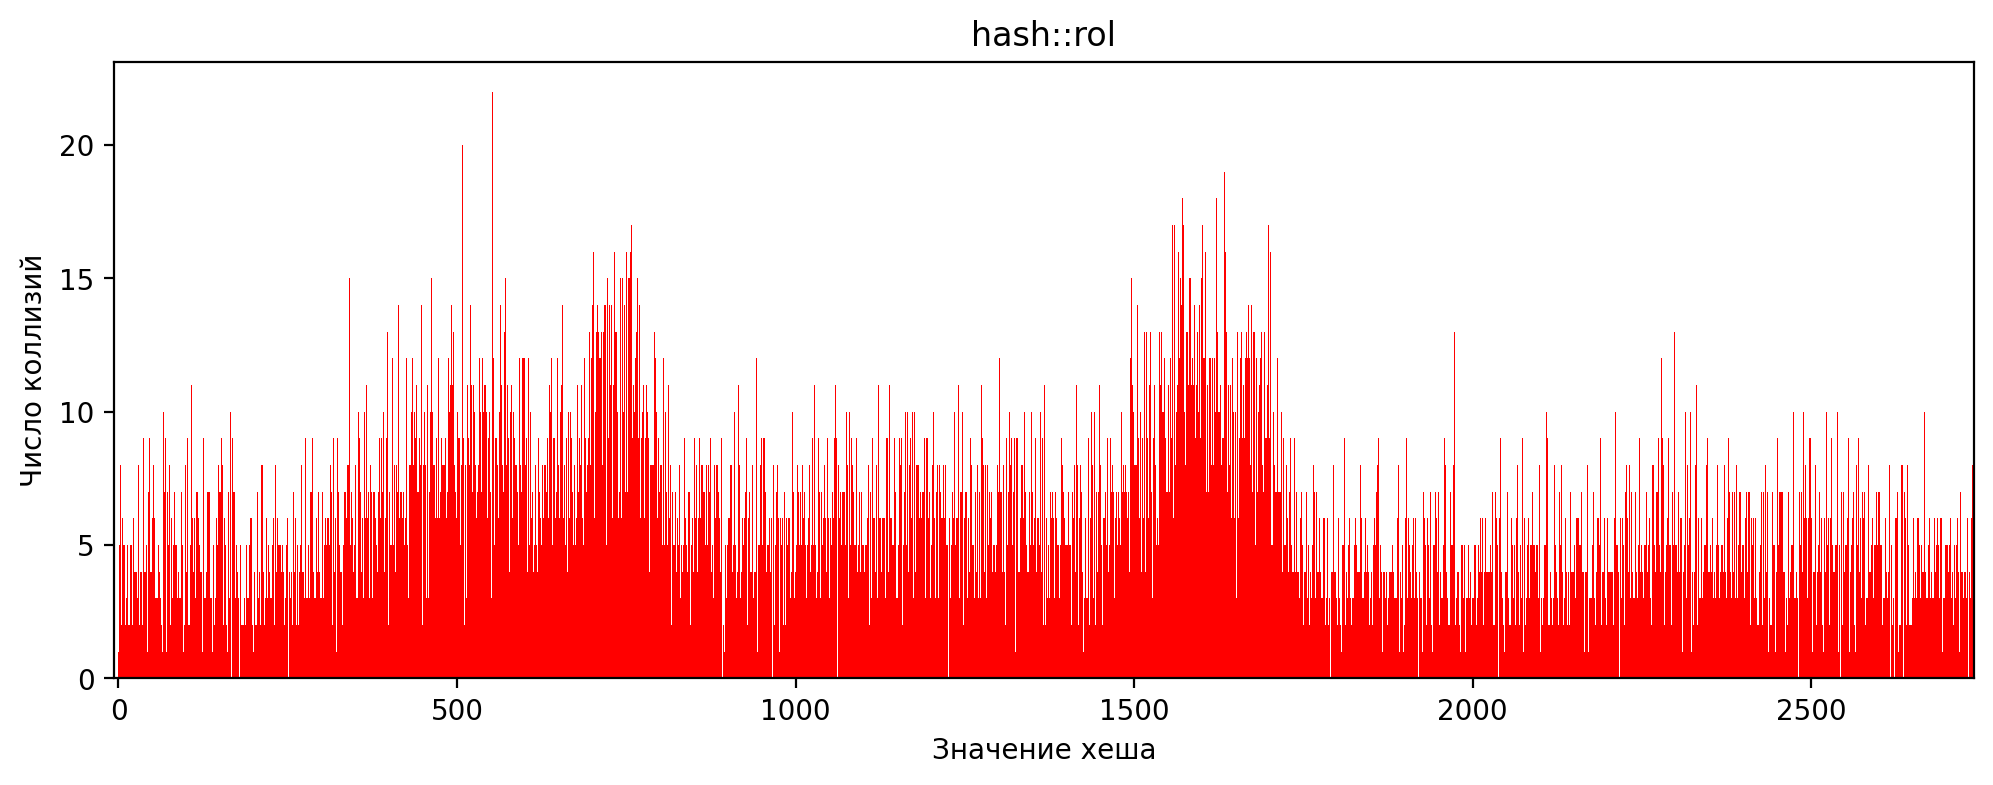

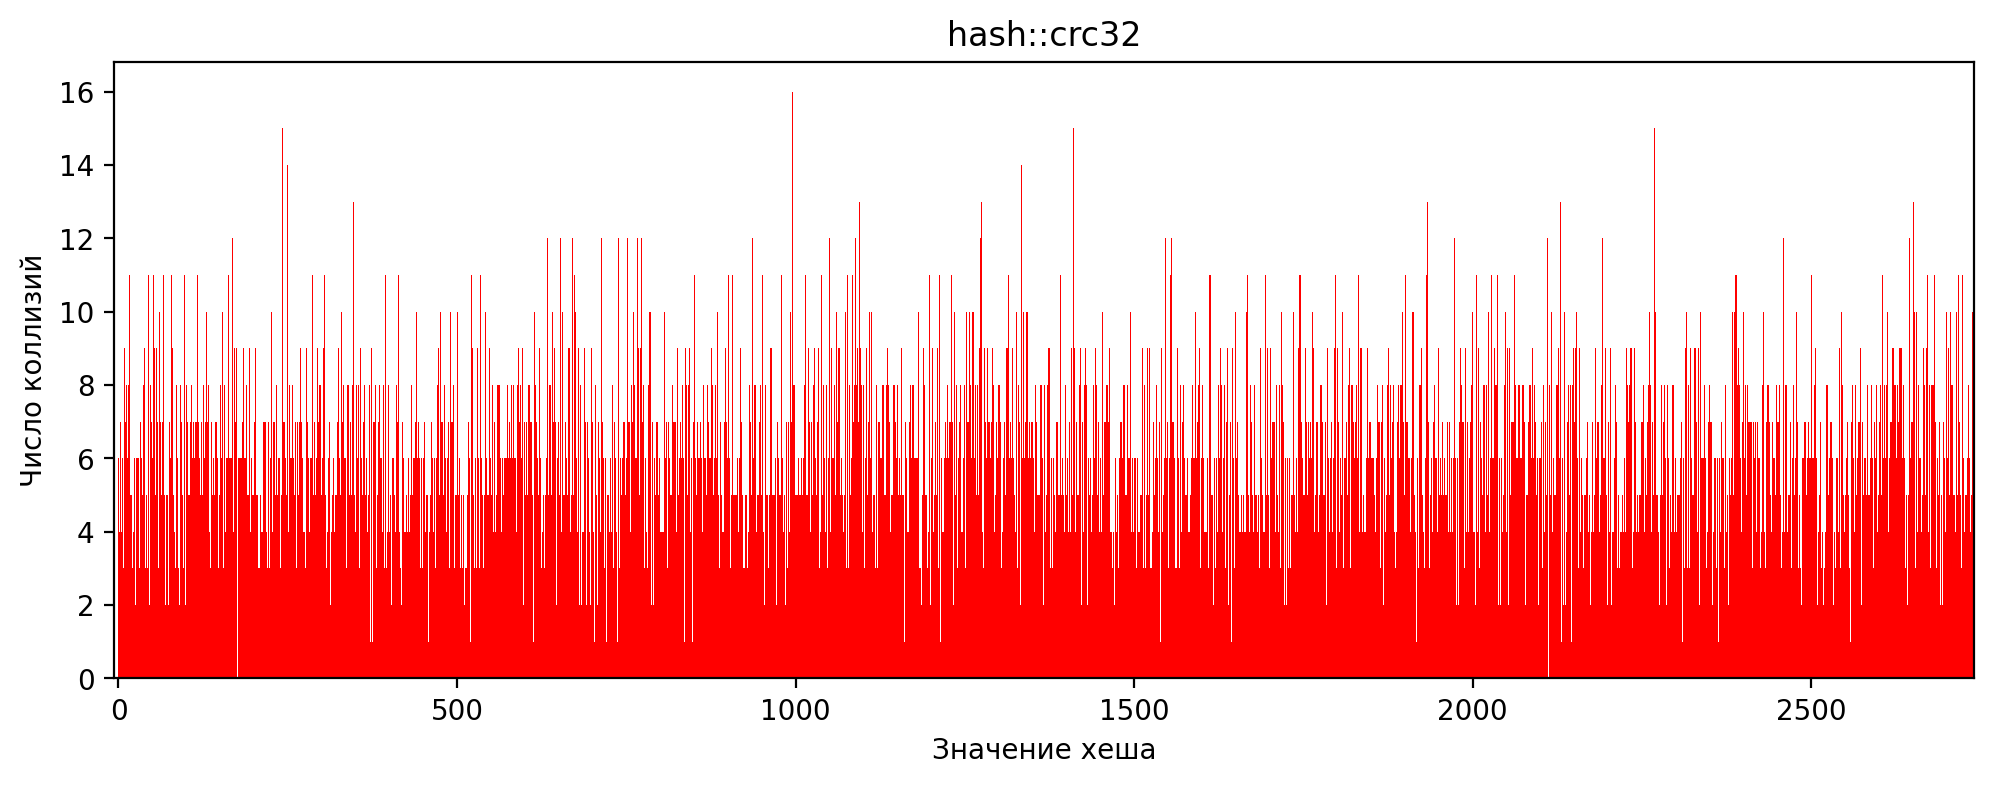

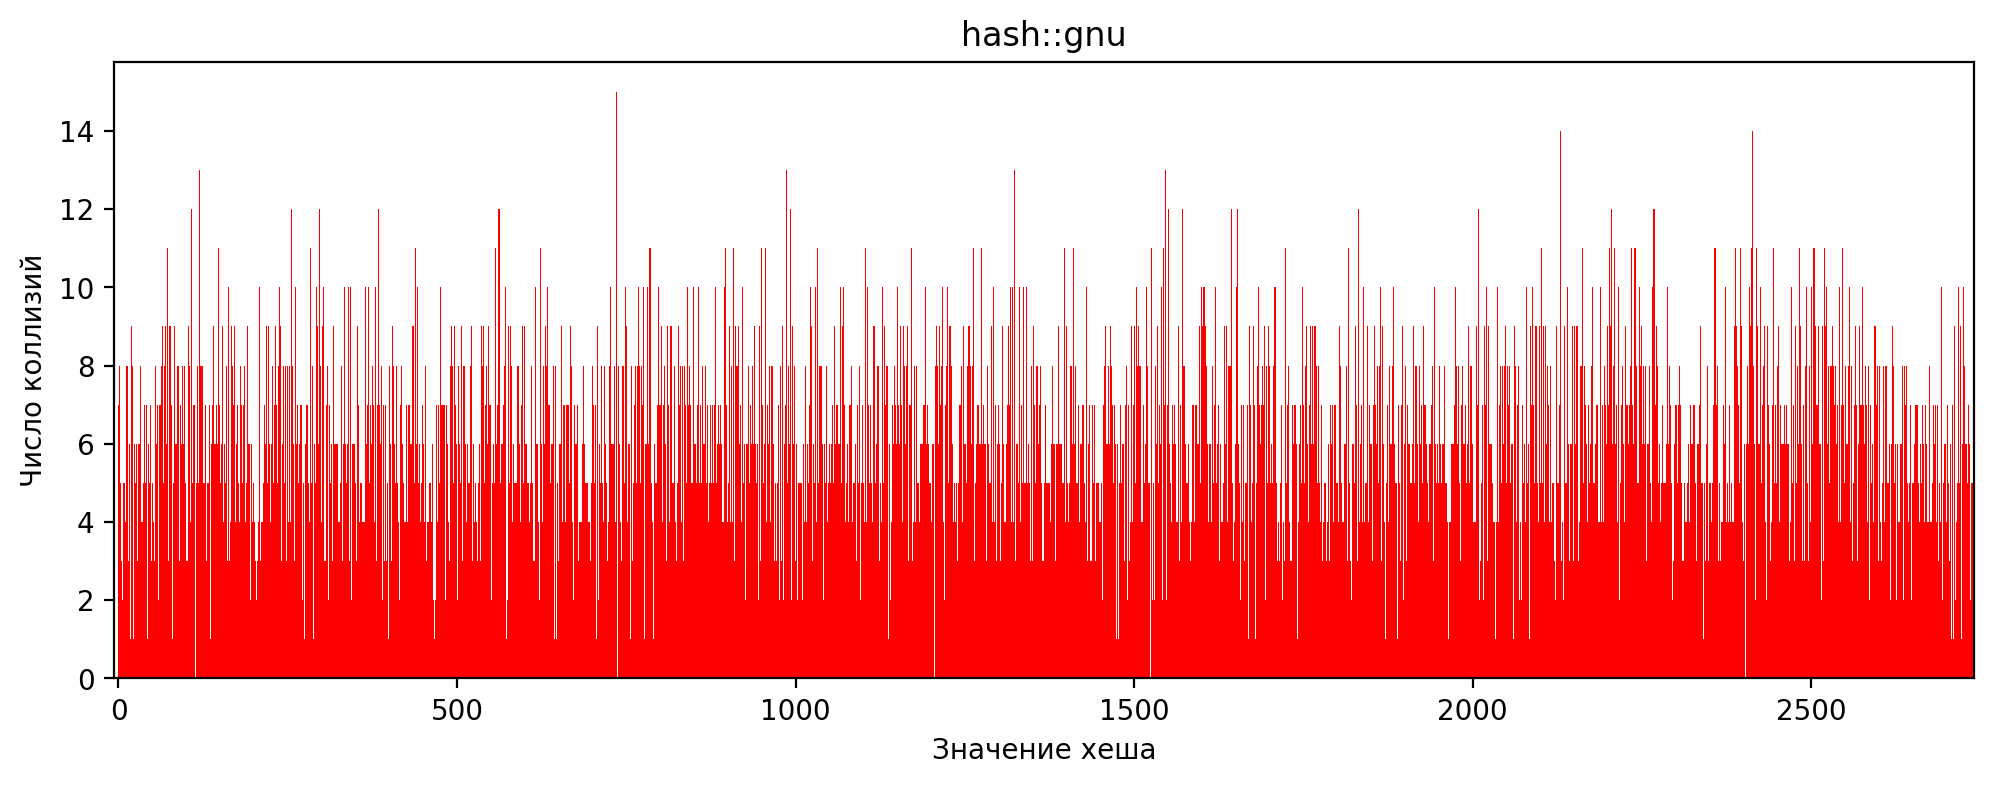

In [3]:
for i in range(nums.__len__()):
    plot_hash_func(nums[i], loads[i], title=HASH_FUNCS[i], xlim=[-0.0025 * max(nums[i]), max(nums[i])])


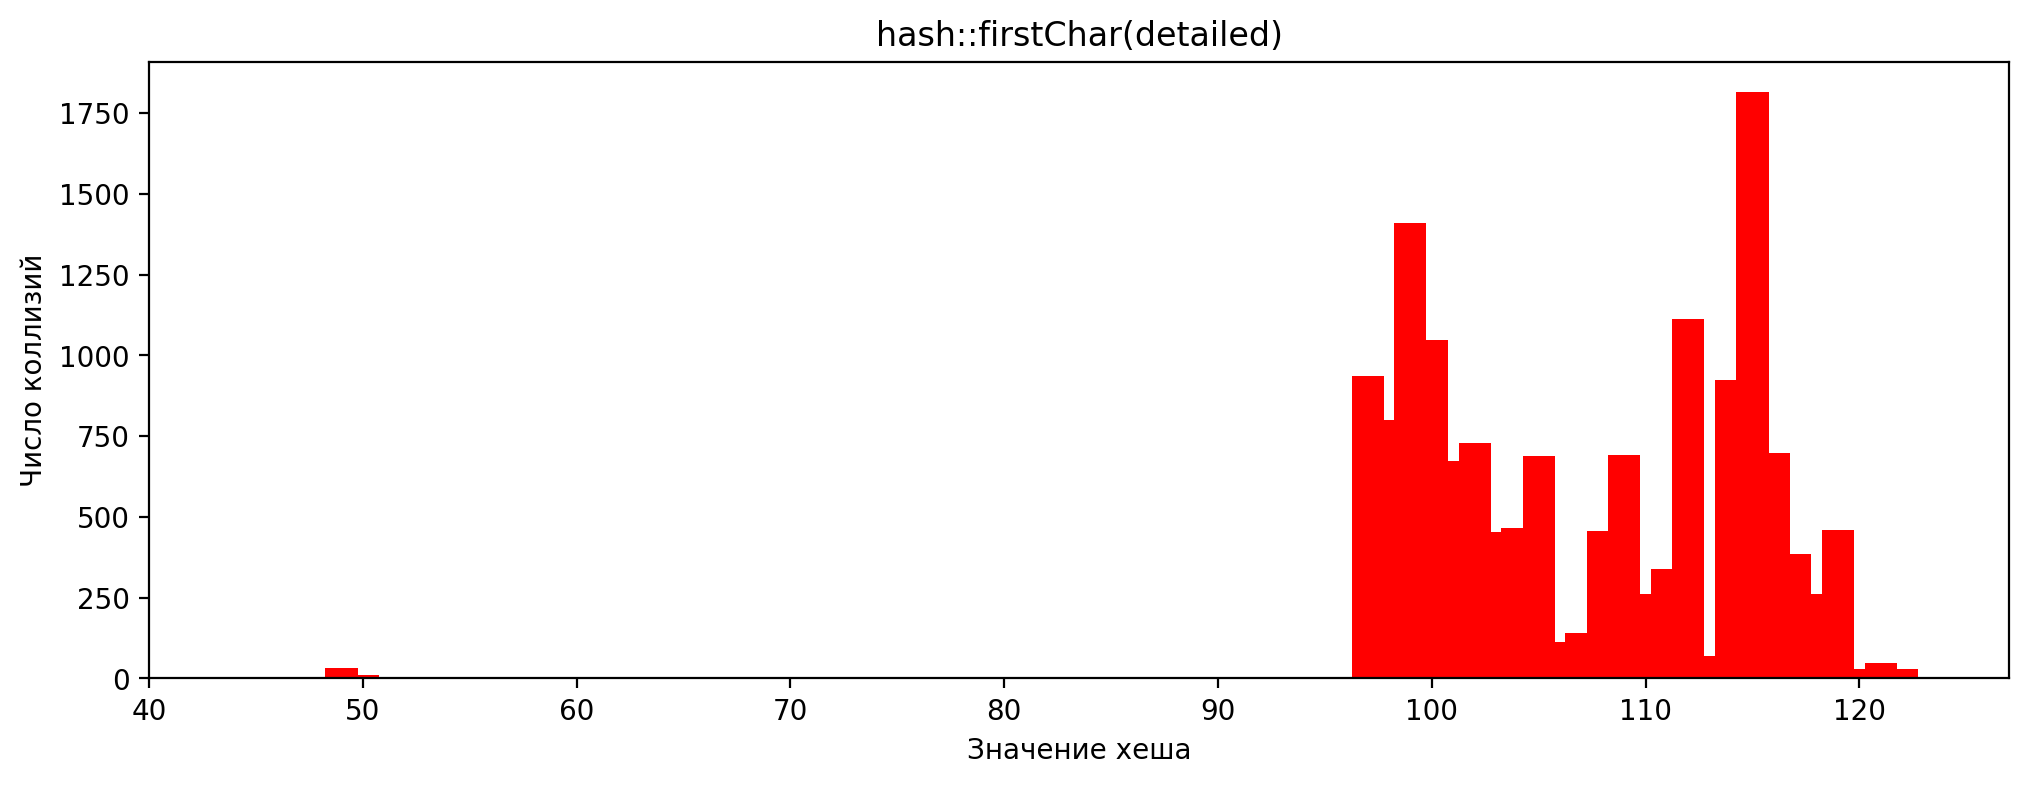

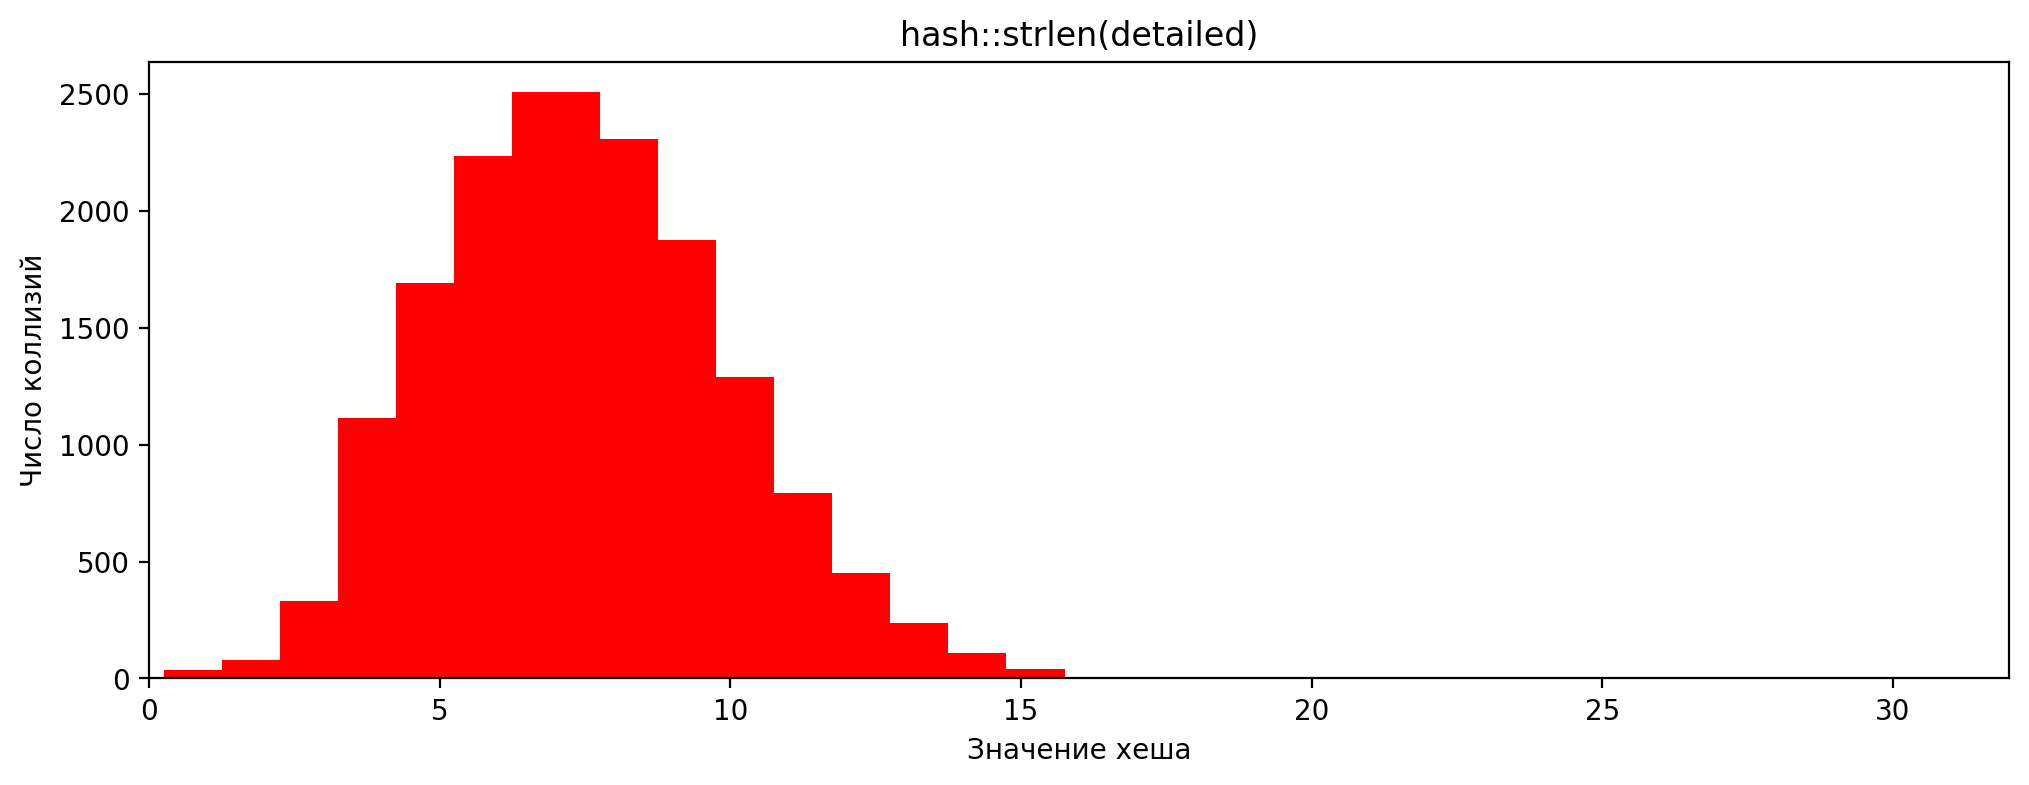

In [4]:
# Detailed bars for hash::firstChar and hash::strlen

xlims = [[0, 0], [40, 127], [0, 32]]

for i in [1, 2]:
    plot_hash_func(nums[i], loads[i], title=f'{HASH_FUNCS[i]}(detailed)', xlim=xlims[i])

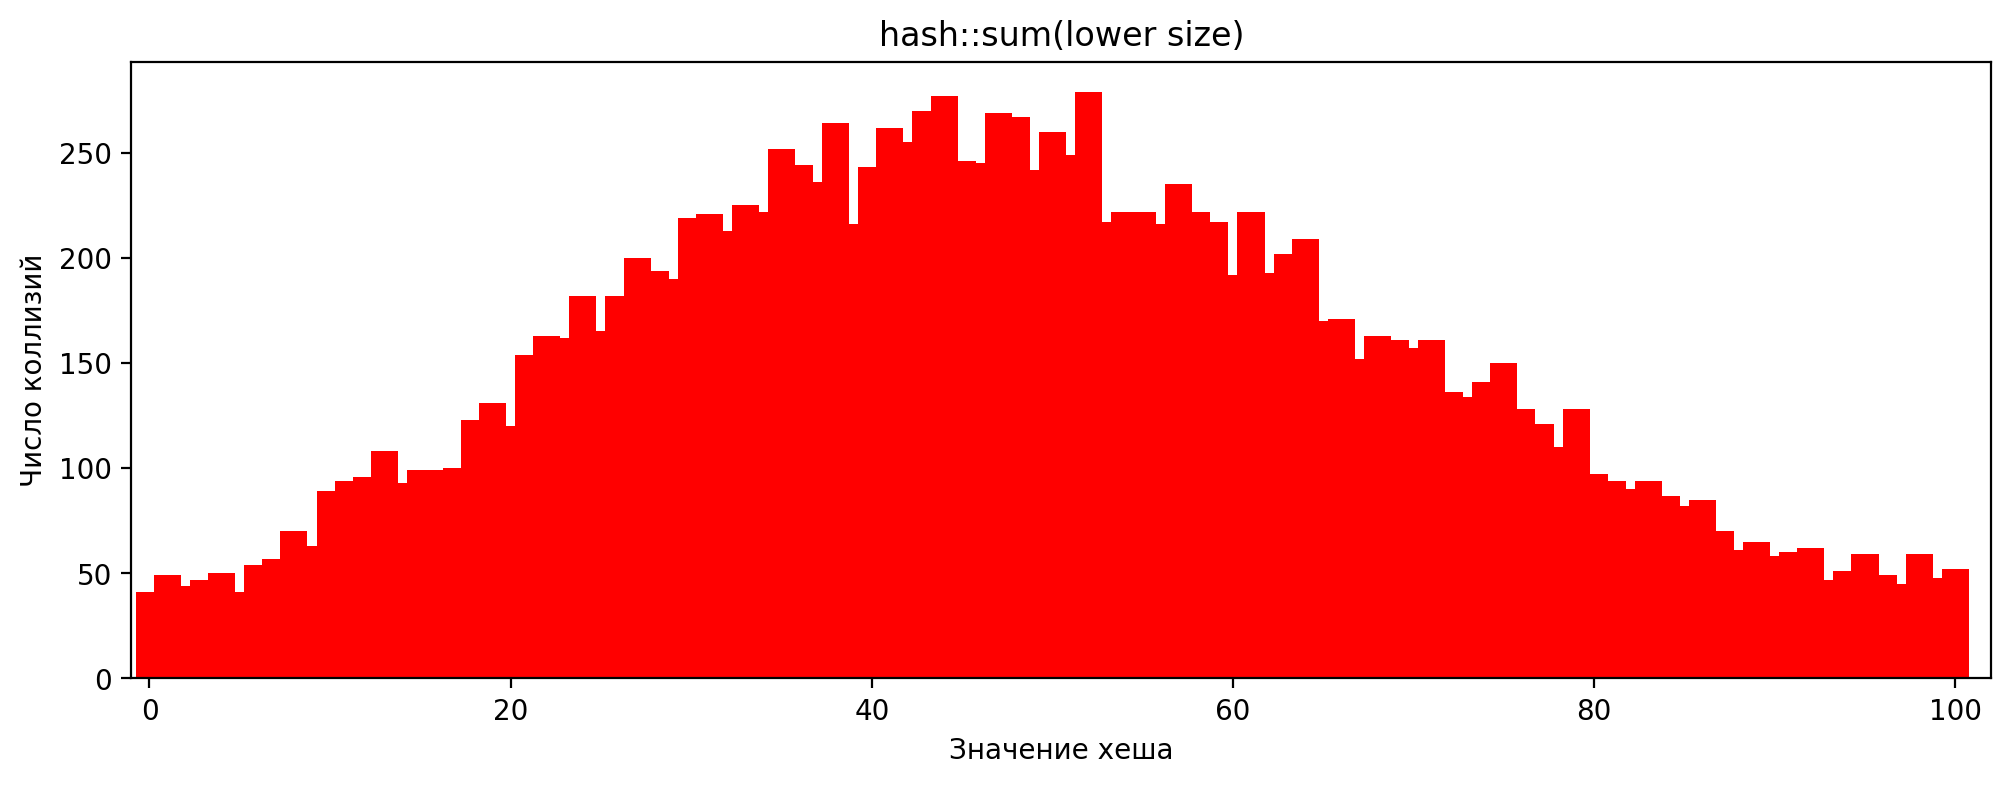

In [5]:
SEPARATE_SUM_HASH_TEST = 'hash::sum(lower size)'

sum_low_size = pd.read_csv(f'{STATS_DIR}/{SEPARATE_SUM_HASH_TEST}.csv')
plot_hash_func(sum_low_size['num'], sum_low_size['load'],
               title=SEPARATE_SUM_HASH_TEST, xlim=[-1, 102])

In [6]:
print('| Хеш | Стандартное отклонение | Время, мс |')
print('|:---:|:----------------------:|:----------:|')

START_IND = 4

HASH_FUNCS.append('hash::crc32_sse')
loads.append(loads[7])
good_hashes = HASH_FUNCS[START_IND:]

times = read_files([f'{STATS_DIR}/{name}_time.csv' for name in good_hashes])
timevals = [t['time'] for t in times]

devs = [0] * HASH_FUNCS.__len__()
avg_times = [0] * good_hashes.__len__()
times_stddev = [0] * good_hashes.__len__()

for i in range(HASH_FUNCS.__len__()):
    devs[i] = np.std(loads[i])
    if i < START_IND:
        print(f'| {HASH_FUNCS[i]} | {devs[i]:.0f} | -- |')
    else:
        avg_times[i - START_IND] = np.mean(timevals[i - START_IND])
        times_stddev[i - START_IND] = np.std(timevals[i - START_IND])
        print(f'| {HASH_FUNCS[i]} | {devs[i]:.1f} | {avg_times[i - START_IND] / 1e6:.2f} ± {times_stddev[i - START_IND] / 1e6:.2f} |')


| Хеш | Стандартное отклонение | Время, мс |
|:---:|:----------------------:|:----------:|
| hash::zero | 288 | -- |
| hash::firstChar | 70 | -- |
| hash::strlen | 99 | -- |
| hash::sum | 12 | -- |
| hash::ror | 4.4 | 4.70 ± 0.09 |
| hash::rol | 3.2 | 4.65 ± 0.05 |
| hash::crc32 | 2.4 | 12.94 ± 0.03 |
| hash::gnu | 2.4 | 4.64 ± 0.02 |
| hash::crc32_sse | 2.4 | 0.98 ± 0.06 |


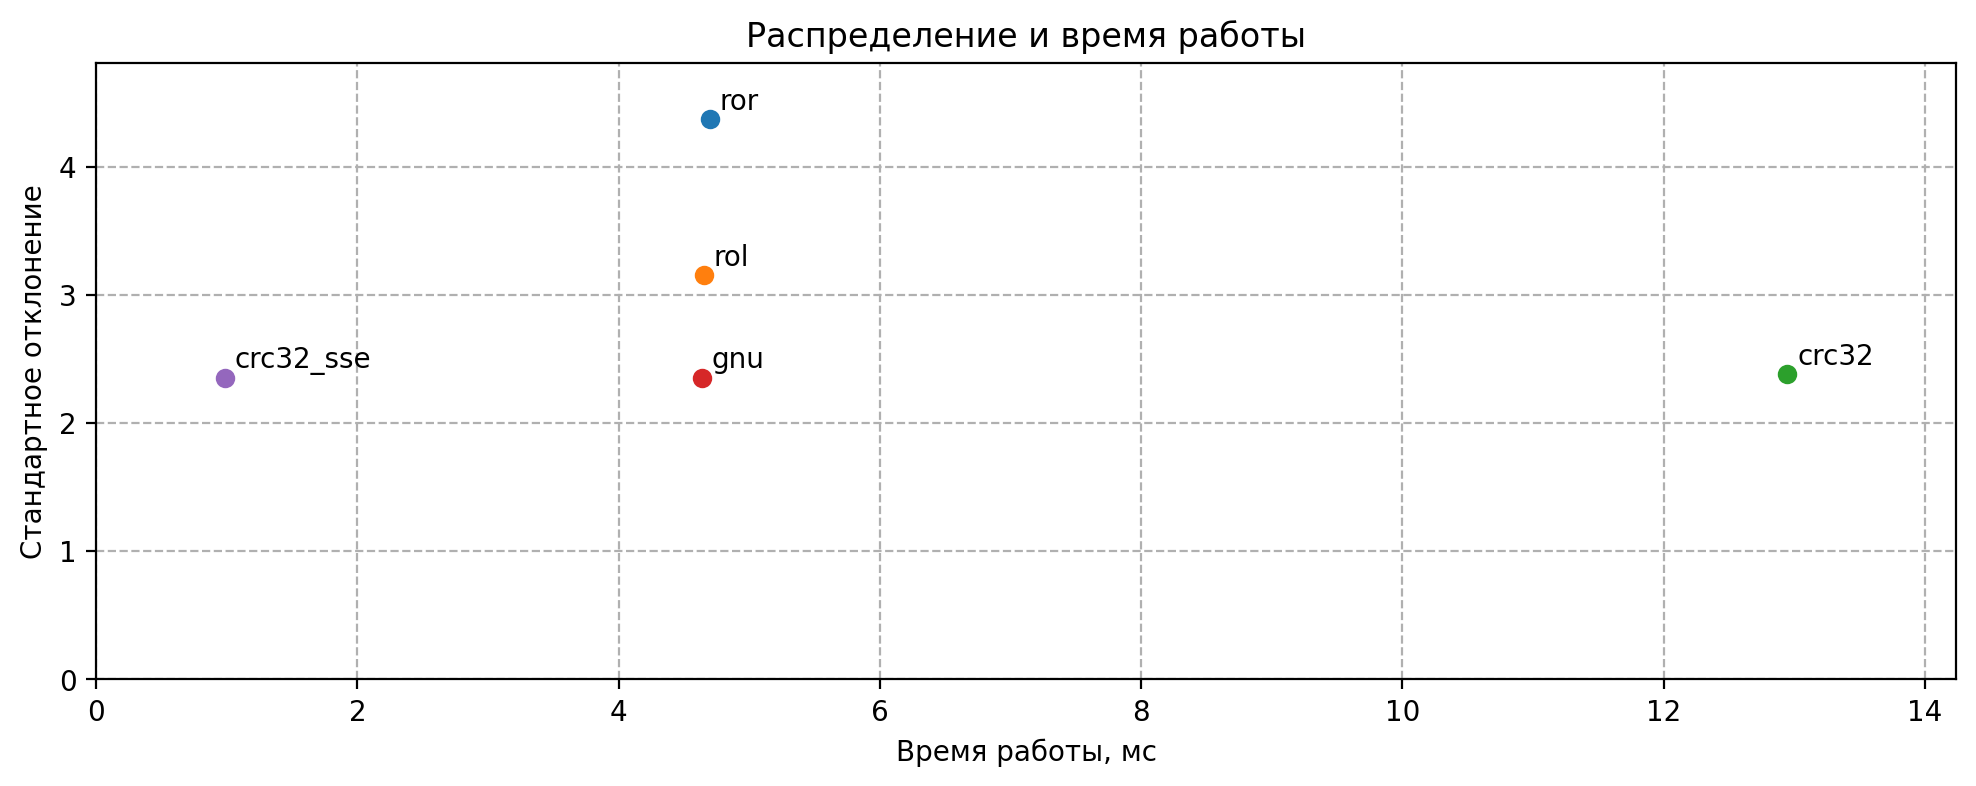

In [7]:
plt.figure(figsize=(12, 4), dpi=200)
plt.ylim(0, max(devs[START_IND:]) * 1.1)
plt.xlim(0, max(avg_times) * 1.1 / 1e6)

for i in range(START_IND, HASH_FUNCS.__len__()):
    plt.scatter([avg_times[i - START_IND] / 1e6], [devs[i]])
    plt.annotate(good_hashes[i - START_IND].removeprefix('hash::'), (avg_times[i - START_IND] / 1e6, devs[i]),
                 xytext=(10, 10), textcoords='offset pixels',
                 size=10)

plt.xlabel('Время работы, мc')
plt.ylabel('Стандартное отклонение')
plt.title('Распределение и время работы')
plt.grid(linestyle='--')
plt.savefig('graphs/dev_time.png')

In [8]:
from scipy.optimize import minimize

def fit(f, params, x, y):
    def err(par, x_, y_):
        y1 = f(par, x_)
        return np.sum((y1-y_)**2)

    return minimize(err, params, args=(x, y)).x

In [36]:
def pow(par, x):
    return par[0] * x**par[1]

-0.5799475389761334

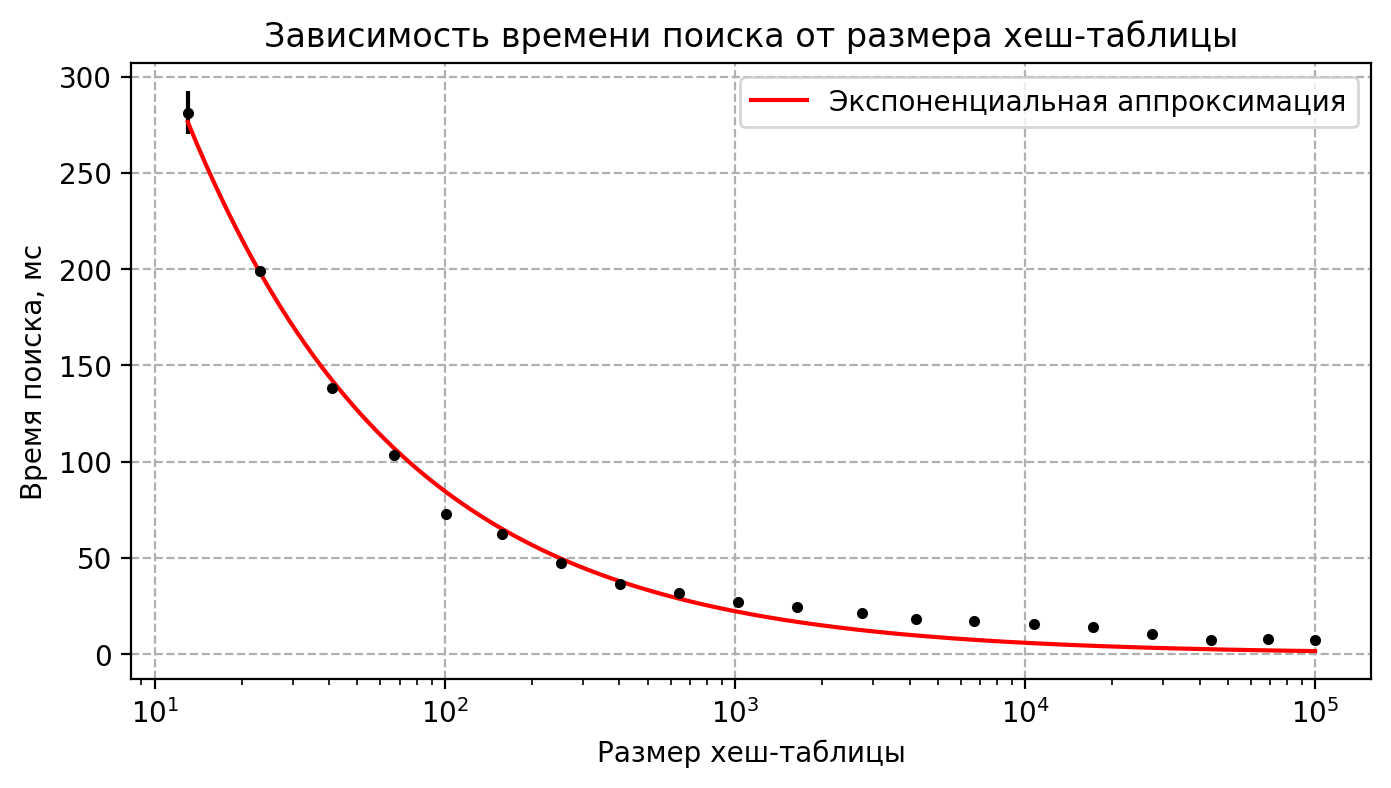

In [42]:
size_time = pd.read_csv('stats/lookup/size_test.csv')

sz = size_time['size']
tm = size_time['time']
stddev = size_time['stddev']

tm /= 1e6
stddev /= 1e6

plt.figure(figsize=(8, 4), dpi=200)
plt.xscale('log')

par = [0, 0]
par = fit(pow, par, sz, tm)
plt.errorbar(sz, tm, yerr=stddev, fmt='k.')
x_ax = np.linspace(min(sz), max(sz), 100000)
plt.plot(x_ax, pow(par, x_ax), color='red', label='Экспоненциальная аппроксимация')

plt.xlabel('Размер хеш-таблицы')
plt.ylabel('Время поиска, мс')
plt.title('Зависимость времени поиска от размера хеш-таблицы')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graphs/size_time.png')

par[1]


In [43]:
par[0]

1223.2435694924445